# Encoding experiment using the fast shared response model (FastSRM)

In this notebook we introduce some basic functionalities of FastSRM and compare its performance to another implementation of SRM (ProbSRM). We present an encoding experiment that shows how fmri data of train subjects can be used to predict fmri data of test subjects (after training).

More precisely, let us assume we have 2 groups of subjects (train, test) exposed to 2 similar but different naturalistic stimuli (session 1 and session 2) while we record their brain activity using an fMRI scanner. 

Our experiment follows the following steps:

- Align train subjects: We train an alignment model on session 1 using train subjects
- Align test subjects: Using data of test subjects during session 1 and the previously fitted model we add test subjects to the model
- Predict test subjects data from train subjects: We use the model to align train subjects during session 2. From the aligned data (shared response) we predict the data of test subjects during session 2.
- Measure performance: We report the R2 score between predicted and actual data.

# Real fMRI data

We'll download a publicly available fMRI dataset and run SRM on these data. This dataset comprises fMRI data for 20 subjects listening to the spoken story Pie Man by Jim O'Grady (archived on the Princeton DataSpace). Note that we use 20 subjects to minimize computational demands for this tutorial and recommend larger sample sizes for publication. The gzipped data archive file is ~1.5 GB in size, and may take a couple minutes to download and unzip. The functional data were acquired with 3 x 3 x 4 mm voxels and 1.5 s TRs. Data were preprocessed using fMRIPrep (Esteban et al., 2018), including spatial normalization to MNI space (the T1-weighted ICBM 2009c Nonlinear Asymmetric template). The data were then smoothed to 6 mm FWHM using AFNI's 3dBlurToFWHM (Cox, 1996). The following confound variables were regressed out using 3dTproject: six head motion parameters (and their first derivatives), framewise displacement, six prinicipal components from an anatomical mask of cerebrospinal fluid (CSF) and white matter, sine/cosine bases for high-pass filtering (cutoff: 0.00714 Hz; 140 s), as well as a linear and quadratic trends. The anatomical template and a brain mask (i.e., excluding skull) are supplied as well. These have been resampled to match resolution of the functional images.

In [1]:
import wget
from time import time
from glob import glob
from os.path import join
import nibabel
from nilearn.image import new_img_like
from nilearn.input_data import NiftiMasker, MultiNiftiMasker
import numpy as np
from joblib import Parallel, delayed
from nilearn.plotting import plot_stat_map
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tarfile

/home/hugo/Research/brainiak/venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Download data tarball from Princeton DataSpace (about 1 Gb to download)
t0 = time()
def update_progress(current, total, width=0):
    bar_length = 80
    progress = current / total
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)
    
wget.download('https://dataspace.princeton.edu/jspui/bitstream/88435/dsp01dz010s83s/6/pieman-isc-tutorial.tgz', 
              'pieman_isc', bar=update_progress)



Progress: [################################################################################] 100.0%


'pieman_isc'

In [3]:
tar = tarfile.open("pieman_isc", "r:gz")
tar.extractall()
tar.close()
print("Done in %.2f seconds" % (time() - t0))

Done in 801.00 seconds


# Step 1: Mask and save the data
- We split our data into two sessions (in order to be able to perform our encoding experiment)
- We mask the data and save them into .npy file

### Note:
We use ``detrend=True`` and ``standardize=True`` in the ``NiftiMasker``. This is standard fMRI preprocessing and is needed for FastSRM to work.

In [4]:
t0 = time()
# the directory where our data are located
data_dir = 'pieman-isc-tutorial'
# Filenames for MRI data; gzipped NIfTI images (.nii.gz)
func_fns = glob(join(data_dir, ('sub-*_task-pieman_space-MNI152NLin2009cAsym'
                                '_desc-tproject_bold.nii.gz')))
# The mask for our data
mask_fn = join(data_dir, 'MNI152NLin2009cAsym_desc-brain_mask.nii.gz')

# Let us mask these data and separate them into two sessions
def separate_and_mask(func):
    # Load data
    N = nibabel.load(func).get_data()
    # Separate them into two sessions
    N_1 = N[:, :, :, :250]
    N_2 = N[:, :, :, 250:]
    I_1 = new_img_like(func, N_1)
    I_2 = new_img_like(func, N_2)
    # Mask data
    masker = NiftiMasker(
        mask_img=mask_fn, 
        detrend=True,
        standardize=True,
        smoothing_fwhm=6
    ).fit()
    # Transpose the data to fit with SRM conventions
    X_1 = masker.transform(I_1).T
    X_2 = masker.transform(I_2).T
    # Save data
    np.save(func[:-7] + "_session_1", X_1)
    np.save(func[:-7] + "_session_2", X_2)

# I have 4 cores in my computer, it you have more increase n_jobs
Parallel(n_jobs=4, verbose=10)(
    delayed(separate_and_mask)(
        func
    ) for func in func_fns)
print("Done in %.2f seconds" % (time() - t0))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   15.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   22.4s
[Parallel(n_jobs=4)]: Done  16 out of  20 | elapsed:   29.8s remaining:    7.5s


Done in 37.37 seconds


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   37.4s finished


# Step 2: mask and save an atlas
- Atlases are used in FastSRM to make computation faster
- Any off-the-shelf big atlas should work (number of regions of the atlas should be larger than number of components used in SRM) we use Basc 444 for our example

In [5]:
def load_atlas(atlas, mask_img):
    # Load masker
    atlas_masker = MultiNiftiMasker(
        mask_img=mask_img).fit()
    X = nibabel.load(atlas).get_data()
    # If the atlas is a deterministic atlas
    # (each region is identified by a number starting from 1)
    if len(X.shape) == 3:
        n_components = len(np.unique(X)) - 1
        xa, ya, za = X.shape
        A = np.zeros((xa, ya, za, n_components + 1))
        for c in np.unique(X)[1:].astype(int):
            X_ = np.copy(X)
            X_[X_ != c] = 0.
            X_[X_ == c] = 1.
            A[:, :, :, c] = X_
        A = atlas_masker.transform(new_img_like(atlas, A))
        A = np.argmax(A, axis=0)
    # If the atlas is a probabilistic atlas
    # (each region is assigned to a component)
    else:
        A = atlas_masker.transform(atlas)
    return A

t0 = time()
from nilearn.datasets import fetch_atlas_basc_multiscale_2015
atlas = fetch_atlas_basc_multiscale_2015(data_dir=data_dir)['scale444']
print(atlas)
A = load_atlas(atlas, mask_fn)
np.save(atlas[:-7], A)
atlas_path = atlas[:-7] + ".npy"
print("Done in %.2f" % (time() - t0))


Dataset created in pieman-isc-tutorial/basc_multiscale_2015



Downloaded 193985 of 193985 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)
Extracting data from pieman-isc-tutorial/basc_multiscale_2015/3cbcf0eeb3f666f55070aba1db9a758f/1861819..... done.


pieman-isc-tutorial/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale444.nii.gz
Done in 24.46


# Step 3: Fit of the model and predict data of left-out subjects
- Load data
- Train model on first session using train subjects 
- Compute shared response on second session using train subjects
- Compute alignment for test subjects using session 1
- Predict data of test subjects during session 2 using the trained model

### Note about input images
##### ProbSRM/DetSRM possible input
- imgs is a list of arrays where element i of the array is a numpy array of shape [n_voxels, n_timeframes] that contains the data of subject i

##### FastSRM possible input
- imgs is a list of arrays where element i of the array is a numpy array of shape [n_voxels, n_timeframes] that contains the data of subject i

- imgs is a list of list of arrays where element i, j of the array is a numpy array of shape [n_voxels, n_timeframes] that contains the data of subject i collected during session j.

- imgs is an np array imgs, imgs[i, j] is a path to the data of subject i collected during session j. Data are loaded with numpy.load and expected shape is [n_voxels, n_timeframes] n_timeframes and n_voxels are assumed to be the same across subjects n_timeframes can vary across sessions. Each voxel’s timecourse is assumed to have mean 0 and variance 1

=> So FastSRM can be used with very large dataset (even those where data cannot be hold in memory)

In [6]:
subjects = [18, 19, 20, 21, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 42]
sessions = [1, 2]

files = np.array([
    [glob(join(data_dir, "sub-%.3i*_session_%i*" %(sub, sess)))[0] 
     for sess in sessions]
    for sub in subjects])

# 20 subjects x 2 sessions file matrix
print("Input shape")
print(files.shape)

Input shape
(20, 2)


In [7]:
def load_and_concat(paths):
    """
    Take an array (n_subjects, n_sessions) of path and yields a list of arrays
    Parameters
    ----------
    paths
    Returns
    -------
    X
    """
    X = []
    for i in range(len(paths)):
        X_i = np.concatenate([np.load(paths[i, j])
                              for j in range(len(paths[i]))], axis=1)
        X.append(X_i)
    return X

In [8]:
from brainiak.funcalign.fastsrm import FastSRM
from brainiak.funcalign.srm import SRM

fastsrm = FastSRM(
    atlas=atlas_path, # the path to basc atlas (we could have used np.load(atlas_path) instead)
    n_components=20,
    n_jobs=1, # Since we use a small dataset paralellization is counter-productive so we do not use it here
    n_iter=10, 
    temp_dir=data_dir, # We will use the disk as if we had a small memory
    low_ram=True, # Let's say I really have a small memory so I need low_ram mode
    aggregate="mean" # transform will return the mean of subject specific shared response
)

probsrm = SRM(
    n_iter=10, # same number of iterations
    features=20 # same number of components
)

models = [("probsrm", probsrm), ("fastsrm", fastsrm)]

In [9]:
from sklearn.model_selection import KFold

# List in which we record for each algo the R2 scores per voxels averaged across subjects
r2_mean = {}
for name, model in models:
    print("Running reconstruction experiment for %s" % name)
    t0 = time()
    # List in which we record for each subject the test R2 scores per voxels
    r2_subjects = []

    # We divide all subjects into train  subjects and test subjects
    for subjects_train, subjects_test in KFold(n_splits=5,
                                        shuffle=True
                                       ).split(np.arange(len(subjects))):

        # First let us train the model on train subjects during session 1
        # # For this we will use an input format that is supported by both FastSRM and SRM: a list of arrays
        train_subjects_session_1 = load_and_concat(files[subjects_train, :][:, :1])
        train_subjects_session_2 = load_and_concat(files[subjects_train, :][:, 1:])
        test_subjects_session_1 = load_and_concat(files[subjects_test, :][:, :1])
        test_subjects_session_2 = load_and_concat(files[subjects_test, :][:, 1:])
        
        n_subjects_train = len(subjects_train)
        n_subjects_test = len(subjects_test)

        # # Let us fit the model on the first session
        model.fit(train_subjects_session_1)


        # Then let us compute the shared response on the second session

        # # With ProbSRM the transform method returns a list of subject-specific responses in shared space
        # # so we need an additional step to aggregate them
        if name == "probsrm":
            shared_session_2 = model.transform(train_subjects_session_2)
            shared_session_2 = np.mean(shared_session_2, axis=0)

        # # With FastSRM we can specify the desired behavior. 
        # # Because we specified aggregate="mean" transform directly returns
        # # the mean of subject-specific responses (aggregate=None would result 
        # # in the same behavior as in ProbSRM)
        if name == "fastsrm":
            shared_session_2 = model.transform(train_subjects_session_2)

        # Now we add test subjects to the model

        # # With ProbSRM we have a function transform subject that returns the basis for 
        # # one specific subject. We will save this in a list
        if name == "probsrm":
            list_basis_test_subjects = [model.transform_subject(x) for x in test_subjects_session_1]

        # # With FastSRM we have a function add subject that takes a list of subjects
        # # new subjects are added to internal basis_list (that can be accessed using .basis_list
        # # but this is usually not necessary)
        # # With FastSRM we need to specify what is the shared response that is used to learn the alignment
        if name == "fastsrm":
            shared_session_1 = model.transform(train_subjects_session_1)
            model.add_subjects(test_subjects_session_1, shared_session_1)
        
        # Then we try to reconstruct the data of test subjects during session 2

        # # ProbSRM does not provide an inverse transform so we need to implement this
        # # (it is rather easy)
        if name == "probsrm":
            reconstructed_data_test_subjects_session_2 = [
                list_basis_test_subjects[i].dot(shared_session_2)
                     for i in range(n_subjects_test)]

        # # FastSRM provides an inverse transform but we need to specify what to reconstruct
        # # New subjects are added at the end of the list so we need to reconstruct the data of the last 
        # # n_subjects_test subjects
        if name == "fastsrm":
            reconstructed_data_test_subjects_session_2 = model.inverse_transform(
                shared_session_2,
                subjects_indexes=np.arange(n_subjects_train, n_subjects_train + n_subjects_test))
        
        # This is the true data we are trying to reconstruct ()
        real_data_test_subjects_session_2 = np.array([np.load(file) for file in files[subjects_test, :][:, 1]])

        for i in range(n_subjects_test):
            diff = reconstructed_data_test_subjects_session_2[i] - real_data_test_subjects_session_2[i]
            r2 = 1 - diff.var(axis=1)
            r2_subjects.append(r2)
        
    r2_mean[name] = np.mean(r2_subjects, axis=0)
    print("Done in %.2f" % (time() - t0))

Running reconstruction experiment for probsrm
Done in 105.25
Running reconstruction experiment for fastsrm
Done in 48.39


# Step 5: Plot results

R2 score probsrm: 0.036
R2 score fastsrm: 0.039


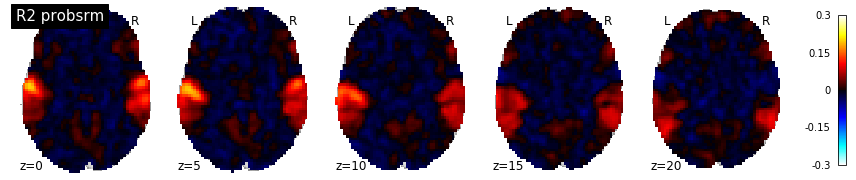

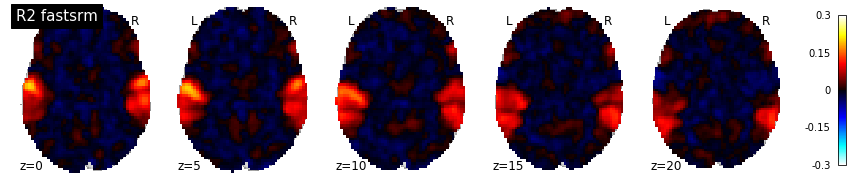

In [10]:
masker = NiftiMasker(
        mask_img=mask_fn).fit()

for name in ["probsrm", "fastsrm"]:
    # R2 score in a ROI given by areas where ProbSRM performs well
    print("R2 score %s: %.3f" % (name, np.mean(r2_mean[name][r2_mean["probsrm"] > 0.01])))
    plot_stat_map(
        masker.inverse_transform(r2_mean[name]),
        display_mode="z",
        cut_coords=[0, 5, 10, 15, 20],
        vmax=0.3,
        title="R2 %s" % name
    )